In [2]:
# from qiskit.opflow import I, Z, X, Y, SparsePauliOp
import numpy as np
from decorator import append

# from juices import Juices
# 假设有 3 台机器和 3 个操作
m = 3  # 机器数量
n = 2  # 操作数量
l = 1  # 用于表示 C_max 的二进制位数

# 处理时间矩阵 (例如)
p = np.array([[1, 2, 3, ], [2, 3, 1]])

# 常数
K1 = 100
P = 30

# 量子比特数量
num_qubits = n * m + l + l * m

In [3]:
# 2. XY_mixer
from qiskit.circuit.library.standard_gates import RYGate
from qiskit import QuantumCircuit, Aer, execute
from math import sqrt
from qiskit.visualization import plot_histogram
import math


def append_SCS_term(m, l, n):
    qc = QuantumCircuit(n, name='SCS_' + str(m) + ',' + str(l))
    m = m - 1
    for i in range(l):
        if (i + 1) == 1:
            qc.cx(m - 1, m)
            theta = sqrt(1 / (m + 1))
            c3ry_gate = RYGate(2 * math.acos(theta)).control(1)
            qc.append(c3ry_gate, [m, m - 1])
            qc.cx(m - 1, m)
        else:
            qc.cx(m - (i + 1), m)
            theta = sqrt((i + 1) / (m + 1))
            c3ry_gate = RYGate(2 * math.acos(theta)).control(2)
            qc.append(c3ry_gate, [m, m - (i + 1) + 1, m - (i + 1)])
            qc.cx(m - (i + 1), m)
    return qc


def get_Dicke_state_init_circuit(n, m, B, l):
    total_qubits = n * m + l + l * m
    qc = QuantumCircuit(total_qubits, name='modified_dicke_init')

    # 对前 n * m 个量子比特分组，每组 m 个量子比特中包含 B 个激发态
    for group in range(n):
        start = group * m  # 每组的起始索引
        for j in range(B):
            qc.x(start + j)  # 在每组的前 B 个比特上施加 X 门，使其为激发态

    # 在每组 m 个量子比特中应用 SCS 子电路生成激励共享态
    for group in range(n):
        start = group * m
        for i in range(m - 1):
            if m - i > B:
                qc.append(append_SCS_term(m - i, B, m), range(start, start + m))
            else:
                qc.append(append_SCS_term(m - i, m - i - 1, m), range(start, start + m))
            qc.barrier()

    # 额外的 l 个量子比特可用于纠缠初始化或其他操作
    for i in range(l + l * m):
        qc.h(n * m + i)

    return qc


In [4]:
def append_multi_rzz_term(qc, qubits, gamma):
    """
    构建一个类RZZ门，n-1个控制位，1个目标位，进行旋转操作。
    参数:
    control_qubits: List[int]，控制量子比特的索引
    target_qubit: int，目标量子比特的索引
    """
    length = len(qubits)

    if length == 1:
        qc.rz(gamma, qubits[0])
    else:
        control_qubits = list(qubits[:length - 1])

        target_qubit = qubits[length - 1]

        n_controls = len(control_qubits)

        if n_controls == 1:
            qc.cx(control_qubits[0], target_qubit)
        else:
            qc.mcx(control_qubits, target_qubit)
        qc.rz(gamma, target_qubit)
        if n_controls == 1:
            qc.cx(control_qubits[0], target_qubit)
        else:
            qc.mcx(control_qubits, target_qubit)

In [5]:
def append__zz_term(qc, qubit1, qubit2, gamma):
    qc.cx(qubit1, qubit2)
    qc.rz(gamma, qubit2)
    qc.cx(qubit1, qubit2)


def append__z_term(qc, qubit, gamma):
    qc.rz(gamma, qubit)


def append__mixer_term(qc, qubit, beta):
    qc.rx(2 * beta, qubit)

In [6]:
def get_cost_circuit1(gamma, qc):
    # beta, gamma = params[:len(params)//2], params[len(params)//2:]
    for h in range(l):
        # print(m * n + h)
        coef = - 2 ** h
        append__z_term(qc, m * n + h, coef * gamma)
    return qc

In [7]:
def get_cost_circuit2(gamma, qc):
    # beta, gamma = params[:len(params)//2], params[len(params)//2:]
    for i in range(n):
        for j in range(m):
            append__z_term(qc, i * m + j, (2 - m) * K1 * gamma)
        # for i in range(n):
        for j1 in range(m):
            for j2 in range(m):
                if j1 != j2:
                    append__zz_term(qc, i * m + j1, i * m + j2, K1 * gamma)
    return qc

In [8]:
def get_cost_circuit3(gamma, qc):
    # beta, gamma = params[:len(params)//2], params[len(params)//2:]
    for j in range(m):
        # n^2
        for i in range(n):
            coef = (- 1 / 2) * p[i, j] * p[i, j]
            append__z_term(qc, i * m + j, 2 * P * coef * gamma)
        for i1 in range(n):
            for i2 in range(n):
                if i1 != i2:
                    coef = 1 / 4 * p[i1, j] * p[i2, j]
                    append__z_term(qc, i1 * m + j, - 2 * P * coef * gamma)
                    append__z_term(qc, i2 * m + j, - 2 * P * coef * gamma)
                    append__zz_term(qc, i1 * m + j, i2 * m + j, 2 * P * coef * gamma)
        # h^2
        for h in range(l):
            coef = - 2 ** (2 * h) * 1 / 2
            append__zz_term(qc, m * n + l + j * l + h, m * n + h, 2 * P * coef * gamma)
        for h in range(l):
            for g in range(l):
                if h != g:
                    coef = 2 ** (h + g) * 1 / 4
                    append__z_term(qc, m * n + l + j * l + g, - 2 * P * coef * gamma)
                    append__z_term(qc, m * n + g, - 2 * P * coef * gamma)
                    append__zz_term(qc, m * n + l + j * l + g, m * n + g, 2 * P * coef * gamma)

                    append__z_term(qc, m * n + l + j * l + h, - 2 * P * coef * gamma)
                    append__zz_term(qc, m * n + l + j * l + h, m * n + l + j * l + g, 2 * P * coef * gamma)
                    append__zz_term(qc, m * n + l + j * l + h, m * n + g, 2 * P * coef * gamma)

                    qubits_index = np.array([m * n + l + j * l + h, m * n + l + j * l + g, m * n + g], dtype=int)
                    append_multi_rzz_term(qc, qubits_index, - 2 * P * coef * gamma)

                    append__z_term(qc, m * n + h, - 2 * P * coef * gamma)
                    append__zz_term(qc, m * n + h, m * n + l + j * l + g, 2 * P * coef * gamma)
                    append__zz_term(qc, m * n + h, m * n + g, 2 * P * coef * gamma)

                    qubits_index = np.array([m * n + h, m * n + l + j * l + g, m * n + g], dtype=int)
                    append_multi_rzz_term(qc, qubits_index, - 2 * P * coef * gamma)

                    append__zz_term(qc, m * n + l + j * l + h, m * n + h, 2 * P * coef * gamma)

                    qubits_index = np.array([m * n + l + j * l + h, m * n + h, m * n + l + j * l + g], dtype=int)
                    append_multi_rzz_term(qc, qubits_index, - 2 * P * coef * gamma)

                    qubits_index = np.array([m * n + l + j * l + h, m * n + h, m * n + g], dtype=int)
                    append_multi_rzz_term(qc, qubits_index, - 2 * P * coef * gamma)

                    qubits_index = np.array([m * n + l + j * l + h, m * n + h, m * n + l + j * l + g, m * n + g],
                                            dtype=int)
                    append_multi_rzz_term(qc, qubits_index, 2 * P * coef * gamma)

        for i in range(n):
            for h in range(l):
                coef = 2 ** (h) * p[i, j]
                append__z_term(qc, m * n + l + j * l + h, - 2 * P * coef * gamma)
                append__z_term(qc, m * n + h, 2 * P * coef * gamma)
                append__z_term(qc, i * m + j, - 2 * P * coef * gamma)

                append__zz_term(qc, i * m + j, m * n + l + j * l + h, 2 * P * coef * gamma)
                append__zz_term(qc, i * m + j, m * n + h, - 2 * P * coef * gamma)
    return qc


In [9]:
def get_mixer_circuit(beta, qc):
    # beta, gamma = params[:len(params)//2], params[len(params)//2:]
    for i in range(num_qubits):
        append__mixer_term(qc, i, beta)
        # qc.barrier()
    return qc

In [10]:
def get_mixer_circuit_xy(beta, qc):
    for i in range(n):
        for j1 in range(m):
            for j2 in range(m):
                if j1 < j2:
                    qc.rxx(2 * beta, i * m + j1, i * m + j2)
                    qc.ryy(2 * beta, i * m + j1, i * m + j2)

In [11]:
def invert_counts(s):
    return s[::-1]

In [12]:
from qiskit.circuit.library import PauliEvolutionGate
from qiskit import Aer, transpile, assemble, QuantumCircuit, execute


# 定义成本函数
def cost_function(params):
    beta, gamma = params[:len(params) // 2], params[len(params) // 2:]
    num_qubits = n * m + l + l * m
    # qc = QuantumCircuit(num_qubits, num_qubits)  # 添加经典寄存器
    B = 1  # 限制1的个数
    dicke_circuit = get_Dicke_state_init_circuit(n, m, B, l)
    qc = QuantumCircuit(num_qubits, num_qubits)
    qc.append(dicke_circuit, range(num_qubits))
    # print(qc)

    length = len(params)
    for i in range(int(length / 2)):
        get_cost_circuit1(gamma[i], qc)
        # get_cost_circuit2(gamma[i], qc)
        get_cost_circuit3(gamma[i], qc)
        get_mixer_circuit_xy(beta[i], qc)
    # 模拟电路
    # 添加测量指令
    qc.measure(range(num_qubits), range(num_qubits))
    backend = Aer.get_backend('qasm_simulator')
    result = execute(qc, backend, seed_simulator=10, shots=10000).result()
    counts = result.get_counts(qc)
    # 计算期望值
    expectation = 0
    for bitstring, count in counts.items():
        bitstring = invert_counts(bitstring)
        prob = count / 10000
        # 提取 x_ij, z_h, τ_jh
        x_ij_bits = bitstring[:n * m]
        z_h_bits = bitstring[n * m:n * m + l]
        tau_jh_bits = bitstring[n * m + l:]

        x_ij = np.array([int(bit) for bit in x_ij_bits]).reshape(n, m)
        z_h = np.array([int(bit) for bit in z_h_bits])
        tau_jh = np.array([int(bit) for bit in tau_jh_bits]).reshape(m, l)  # 注意 τ_jh 的维度为 (m, l)

        # 计算目标函数的每部分
        # 第1部分: ∑ 2^h * z_h
        E1 = np.sum([2 ** h * z_h[h] for h in range(l)])

        # 第2部分: K1 * ∑ (∑ x_ij - 1)^2
        E2 = K1 * np.sum((np.sum(x_ij, axis=1) - 1) ** 2)

        # 第3部分: K2 * ∑ (∑ x_ij * p_ij + ∑ 2^h (τ_jh - z_h))^2
        E3 = 0
        for j in range(m):
            sum_xp = np.sum([x_ij[i, j] * p[i, j] for i in range(n)])  # ∑ x_ij * p_ij
            sum_tau_z = np.sum([2 ** h * (tau_jh[j, h] - z_h[h]) for h in range(l)])  # ∑ 2^h (τ_jh - z_h)
            E3 += P * (sum_xp + sum_tau_z) ** 2

        # 目标函数值
        f_value = E1 + E2 + E3
        expectation += f_value * prob  # 累加加权值

    return expectation, counts

In [12]:
from qiskit_algorithms.optimizers import COBYLA


# 优化 QAOA 参数
def optimize_qaoa(params):
    def objective(params):
        expectation, _ = cost_function(params)

        return expectation

    optimizer = COBYLA(rhobeg=1.5, tol=1e-7)
    # params = np.random.rand(2 * p_max) * 2 * np.pi
    result = optimizer.minimize(fun=objective, x0=params)

    return result

In [13]:
import time

# 运行优化
# p_max = 6  # 最大层数

startTime = time.time()
ansatz_final = object()
init_point = np.array([])
counts = {}
min_energy = 0
final_result = object()
for p1 in range(1, 4):
    min_energy = 10000
    for k in range(100):
        print('第：', p1, '层', ' ', '第', k, '个参数')
        init_point_temp = init_point
        beta_p = np.random.uniform(0, np.pi)
        gamma_p = np.random.uniform(0, 2 * np.pi)
        if k > 0:
            init_point_temp = np.delete(init_point_temp, 2 * p1 - 1)
            init_point_temp = np.delete(init_point_temp, p1 - 1)
        init_point_temp = np.insert(init_point_temp, p1 - 1, beta_p)
        init_point_temp = np.insert(init_point_temp, 2 * p1 - 1, gamma_p)
        # 创建参数向量
        # print("init_point_temp"+ init_point_temp)
        result = optimize_qaoa(init_point_temp)

        # print(result.x)
        optimal_params = result.x

        # 计算最终的能量
        energy, counts_temp = cost_function(result.x)
        # 寻找这20对点中最优的参数
        if min_energy > energy:
            min_energy = energy
            init_point = optimal_params
            counts = counts_temp
            final_result = result
endTime = time.time()
# params = np.random.rand(2 * p_max,2*np.pi)
# result = optimize_qaoa(n, m, l, K1, P, p, params)

第： 1 层   第 0 个参数
第： 1 层   第 1 个参数
第： 1 层   第 2 个参数
第： 1 层   第 3 个参数
第： 1 层   第 4 个参数
第： 1 层   第 5 个参数
第： 1 层   第 6 个参数
第： 1 层   第 7 个参数
第： 1 层   第 8 个参数
第： 1 层   第 9 个参数
第： 1 层   第 10 个参数
第： 1 层   第 11 个参数
第： 1 层   第 12 个参数
第： 1 层   第 13 个参数
第： 1 层   第 14 个参数
第： 1 层   第 15 个参数
第： 1 层   第 16 个参数
第： 1 层   第 17 个参数
第： 1 层   第 18 个参数
第： 1 层   第 19 个参数
第： 1 层   第 20 个参数
第： 1 层   第 21 个参数
第： 1 层   第 22 个参数
第： 1 层   第 23 个参数
第： 1 层   第 24 个参数
第： 1 层   第 25 个参数
第： 1 层   第 26 个参数
第： 1 层   第 27 个参数
第： 1 层   第 28 个参数
第： 1 层   第 29 个参数
第： 1 层   第 30 个参数
第： 1 层   第 31 个参数
第： 1 层   第 32 个参数
第： 1 层   第 33 个参数
第： 1 层   第 34 个参数
第： 1 层   第 35 个参数
第： 1 层   第 36 个参数
第： 1 层   第 37 个参数
第： 1 层   第 38 个参数
第： 1 层   第 39 个参数
第： 1 层   第 40 个参数
第： 1 层   第 41 个参数
第： 1 层   第 42 个参数
第： 1 层   第 43 个参数
第： 1 层   第 44 个参数
第： 1 层   第 45 个参数
第： 1 层   第 46 个参数
第： 1 层   第 47 个参数
第： 1 层   第 48 个参数
第： 1 层   第 49 个参数
第： 1 层   第 50 个参数
第： 1 层   第 51 个参数
第： 1 层   第 52 个参数
第： 1 层   第 53 个参数
第： 1 层   第 54 个参数
第： 1 层   第 55 个参数
第：

优化时间： 3530.011161804199
Optimal parameters: [9.66743434 5.5083692  4.53365334 5.60174486 7.38268787 4.08509156]
Optimal value: 183.3563999999999
Final expectation value: 183.3563999999999
Final measurement counts: {'0100011100': 448, '0100011101': 436, '0100011000': 397, '0100011110': 392, '0100011111': 383, '0100010001': 371, '0100011001': 369, '0100010100': 365, '0100010000': 364, '0100010101': 356, '0100011011': 349, '0100010111': 342, '0100011010': 340, '0100010110': 316, '0100010010': 294, '0100010011': 280, '1000010111': 238, '1000010011': 222, '1000010010': 221, '1000010001': 210, '1000011011': 198, '1000011111': 191, '1000011010': 191, '1000010110': 188, '1000010000': 186, '1000010101': 170, '1000011110': 168, '1000011101': 160, '1000011001': 150, '1000010100': 150, '1000011000': 138, '1000011100': 97, '1001001011': 48, '1001000011': 44, '1001000010': 43, '1001001001': 42, '1001001000': 39, '1001001110': 36, '1001001010': 36, '1001000100': 35, '1000100011': 32, '1001000111': 32

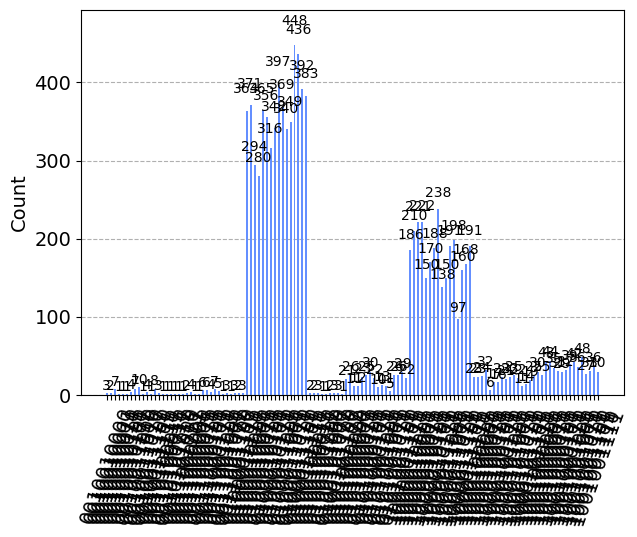

In [15]:
# 输出结果
print("优化时间：", endTime - startTime)
print("Optimal parameters:", final_result.x)
print("Optimal value:", final_result.fun)
# 使用最优参数运行量子电路并输出测量结果
final_expectation, final_counts = cost_function(final_result.x)
# sorted_dict = dict(sorted(final_counts.items(), key=lambda item: item[1], reverse=True))
sorted_dict = {item[0][::-1]: item[1] for item in sorted(final_counts.items(), key=lambda item: item[1], reverse=True)}
print("Final expectation value:", final_expectation)
print("Final measurement counts:", sorted_dict)
plot_histogram(sorted_dict)

In [29]:
expectation = 0
bitstring = "1000100"
x_ij_bits = bitstring[:n * m]
z_h_bits = bitstring[n * m:n * m + l]
tau_jh_bits = bitstring[n * m + l:]

x_ij = np.array([int(bit) for bit in x_ij_bits]).reshape(n, m)
z_h = np.array([int(bit) for bit in z_h_bits])
tau_jh = np.array([int(bit) for bit in tau_jh_bits]).reshape(m, l)  # 注意 τ_jh 的维度为 (m, l)

# 计算目标函数的每部分
# 第1部分: ∑ 2^h * z_h
E1 = np.sum([2 ** h * z_h[h] for h in range(l)])

# 第2部分: K1 * ∑ (∑ x_ij - 1)^2
E2 = K1 * np.sum((np.sum(x_ij, axis=1) - 1) ** 2)

# 第3部分: K2 * ∑ (∑ x_ij * p_ij + ∑ 2^h (τ_jh - z_h))^2
E3 = 0
for j in range(m):
    sum_xp = np.sum([x_ij[i, j] * p[i, j] for i in range(n)])  # ∑ x_ij * p_ij
    sum_tau_z = np.sum([2 ** h * (tau_jh[j, h] - z_h[h]) for h in range(l)])  # ∑ 2^h (τ_jh - z_h)
    E3 += P * (sum_xp + sum_tau_z) ** 2

# 目标函数值
f_value = E1 + E2 + E3
print(E1)
print(E2)
print(E3)
# print(e1)
# print(e2)

ValueError: cannot reshape array of size 0 into shape (3,1)